### Import libraries

In [1]:
import sys
sys.path.insert(1, '../')
import os
import re
import json
import pandas as pd
import numpy as np
import pickle
from main.helpers.transition_emission import create_dictionaries, create_transition_matrix
from main.helpers.predition_initialization import get_prep
from main.helpers.init import initialize
from main.helpers.viterbi import viterbi_forward, viterbi_backward
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt

### Set pathes

In [2]:
path_to_model = "./data/pos_matrices_country/model/xgb_clf3.pkl"
PATH_TO_ORIGINAL_AB = './data/pos_matrices'
PATH_TO_COUNTRY_AB = './data/pos_matrices_country'
DIR_FULL_FILES = 'shuffled_data_pos_tags_matrices_full_article'
DIR_FULL_FILES2 = 'shuffled_data_pos_tags_matrices_full_article2'
VOCAB_COVID = os.path.join(PATH_TO_ORIGINAL_AB, 'vocab_covid.txt')
USA_PATH = os.path.join(PATH_TO_COUNTRY_AB, 'usa')
CHINA_PATH = os.path.join(PATH_TO_COUNTRY_AB, 'china')
ITALY_PATH = os.path.join(PATH_TO_COUNTRY_AB, 'italy')
GERMANY_PATH = os.path.join(PATH_TO_COUNTRY_AB, 'germany')
TAG_COUNTS = './data/pos_matrices/tag_counts.json'

### Base variables

In [3]:
fixed_valid_train_files = {'usa': None, 'germany': None, 'italy': None, 'china': None}
dict_country_unique_num = {'usa': 1, 'china': 2, 'italy': 3, 'germany': 4}
xgb_model_loaded = pickle.load(open(path_to_model, "rb"))
country_path_dict = {'usa': USA_PATH, 'china': CHINA_PATH, 'italy': ITALY_PATH, 'germany': GERMANY_PATH}

In [4]:
# Import A and B
A_df = pd.read_csv(os.path.join(PATH_TO_ORIGINAL_AB, 'A_df.csv'), index_col=0)
B_df = pd.read_csv(os.path.join(PATH_TO_ORIGINAL_AB, 'B_df.csv'), index_col=0)

A_shape = (23, 23)
B_shape = (23, 51935)
A = A_df.to_numpy()
B = B_df.to_numpy()
assert A.shape == A_shape, 'Wrong A shape'
assert B.shape == B_shape, 'Wrong B shape'

In [5]:
# Import vocab
f_vocab = open(VOCAB_COVID, 'r')
vocab = {el.replace('\n', ''): i for i, el in enumerate(f_vocab)}
f_vocab.close()

In [6]:
# Import tag_counts
f = open(TAG_COUNTS, 'r')
tag_counts = json.load(f)
f.close()

In [7]:
# Import states
states = list(A_df.index.values)
', '.join(states)

'ADJ, ADP, ADV, AUX, CCONJ, CONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SPACE, SYM, VDB, VDD, VDN, VDZ, VERB, X'

### Base functions

In [8]:
def get_text_by_uid(cord_uid):
    return df_ready[df_ready['cord_uid'] == cord_uid].text.values[0]

def get_country_by_uid(cord_uid):
    return df_ready[df_ready['cord_uid'] == cord_uid].country.values[0].lower()

def check_if_all_the_states_in_tag_counts(states, tag_counts):
    for tag in states:
        if (tag_counts).get(tag, None) is None:
            tag_counts[tag] = 0
    return tag_counts

### Predict country by text

In [9]:
# create dictionary of files for train & test
fixed_valid_train_files = {'usa': None, 'germany': None, 'italy': None, 'china': None}
for k in fixed_valid_train_files.keys():
    fixed_valid_train_files[k] = {'train': [], 'test': []}

train_size_alpha = 0.8
# choose which files should go where
for country_name, country_path in country_path_dict.items():
    print(f'\nCountry {country_name}')
    cur_section = 'shuffled_data_pos_tags'
    tagged_data_path = os.path.join(country_path, cur_section)
    print('tagged_data_path = ', tagged_data_path, '; len = ', len(os.listdir(tagged_data_path)))
    
    lst_of_files = list(filter(lambda x: x != '', list(map(lambda x: x.split('.')[0], os.listdir(tagged_data_path)))))
    print('Number of files that we have in .../shuffled_data_pos_tags directory: ', len(lst_of_files))
    len_of_train = int(len(lst_of_files) * train_size_alpha)
    print('Train set size:', len_of_train)
    len_of_test = len(lst_of_files) - len_of_train
    print('Test set size:', len_of_test)
    fixed_valid_train_files[country_name]['train'] = np.random.choice(lst_of_files, len_of_train, replace=False)
    fixed_valid_train_files[country_name]['test'] = np.array([x for x in lst_of_files \
                                                     if not x in fixed_valid_train_files[country_name]['train']])
    print('Is there union?', set(fixed_valid_train_files[country_name]['train']).intersection(set(fixed_valid_train_files[country_name]['test'])))


Country usa
tagged_data_path =  ./data/pos_matrices_country/usa/shuffled_data_pos_tags ; len =  896
Number of files that we have in .../shuffled_data_pos_tags directory:  896
Train set size: 716
Test set size: 180
Is there union? set()

Country china
tagged_data_path =  ./data/pos_matrices_country/china/shuffled_data_pos_tags ; len =  896
Number of files that we have in .../shuffled_data_pos_tags directory:  896
Train set size: 716
Test set size: 180
Is there union? set()

Country italy
tagged_data_path =  ./data/pos_matrices_country/italy/shuffled_data_pos_tags ; len =  896
Number of files that we have in .../shuffled_data_pos_tags directory:  896
Train set size: 716
Test set size: 180
Is there union? set()

Country germany
tagged_data_path =  ./data/pos_matrices_country/germany/shuffled_data_pos_tags ; len =  896
Number of files that we have in .../shuffled_data_pos_tags directory:  896
Train set size: 716
Test set size: 180
Is there union? set()


In [10]:
lst = []
for country_name, country_path in country_path_dict.items():
    print('Country: ', country_name)
    path_to_AB = os.path.join(country_path, DIR_FULL_FILES2)
    for file_name in fixed_valid_train_files[country_name]['test']:
        lst.append((file_name, country_name))
#         file_with_a_file_name = [file for file in os.listdir(path_to_AB) if file_name in file][0]
#         full_file_path = os.path.join(path_to_AB, file_with_a_file_name)
lst

Country:  usa
Country:  china
Country:  italy
Country:  germany


[('rdd99ct5', 'usa'),
 ('gm0qhysr', 'usa'),
 ('gt247nwe', 'usa'),
 ('e01q6pns', 'usa'),
 ('gpth5jul', 'usa'),
 ('369kvq5r', 'usa'),
 ('j036zxcb', 'usa'),
 ('1m071lab', 'usa'),
 ('7dsfnm5y', 'usa'),
 ('94x0bf18', 'usa'),
 ('t080mykk', 'usa'),
 ('x96ilmp9', 'usa'),
 ('rgxiatbv', 'usa'),
 ('bupfw5la', 'usa'),
 ('qf8zun2v', 'usa'),
 ('xmze83ag', 'usa'),
 ('1akmys78', 'usa'),
 ('n74wvika', 'usa'),
 ('5keocn1n', 'usa'),
 ('vi2fb43t', 'usa'),
 ('r6a5vxl0', 'usa'),
 ('mio4przi', 'usa'),
 ('kam36p8n', 'usa'),
 ('g844u7xg', 'usa'),
 ('05y9re12', 'usa'),
 ('nq3lsle6', 'usa'),
 ('rcrmolum', 'usa'),
 ('mndcsejn', 'usa'),
 ('bgdcm1i1', 'usa'),
 ('th7ke15k', 'usa'),
 ('1ysn0kyr', 'usa'),
 ('fyjlheld', 'usa'),
 ('w0zqxwdh', 'usa'),
 ('h19fq32v', 'usa'),
 ('9dldbs6o', 'usa'),
 ('3d8up3zo', 'usa'),
 ('ezv6xp16', 'usa'),
 ('luduq5co', 'usa'),
 ('sw8bo4c7', 'usa'),
 ('pgsode64', 'usa'),
 ('ff4937mj', 'usa'),
 ('t2g1mczl', 'usa'),
 ('ip912edx', 'usa'),
 ('7wcjqhbq', 'usa'),
 ('gp65fb3e', 'usa'),
 ('9v4zxym

### Import data to test the classifier

In [11]:
df_ready = pd.read_csv('./data/paper_country_the_biggest.csv')

def custom_split(text):
    return list(filter(lambda x: not(x == '' or x == ' '), re.split(r'(\b[^\s]+\b)', text.strip())))

In [12]:
num_times = len(states) # in other words: int(len(states)**2/len(states))
all_states = []
for time in range(num_times):
    all_states += list(map(lambda x: states[time] + '_' + x, states))


### Predict

In [27]:
# cord_uid = 'dvu9d5tb'
# cord_uid = 'dvuxuf3q'
# cord_uid = 'stba2epw'
# cord_uid = 'ibnudp1x'
# cord_uid = 'a2cyr3at'
cord_uid = '56h2jmn9'
# cord_uid = 'jjh24ipb'
# cord_uid = '3wvl71cj'

article_of_uid = get_text_by_uid(cord_uid)
labled_country_of_uid = get_country_by_uid(cord_uid)

text_words = custom_split(article_of_uid)
orig, prep_text = get_prep(text_words, vocab)

# print(len(prep_text))
best_probs, best_paths = initialize(states, tag_counts, A, B, prep_text, vocab)
best_probs, best_paths = viterbi_forward(A, B, prep_text, best_probs, best_paths, vocab)

pred_text = viterbi_backward(best_probs, best_paths, prep_text, states)

assert len(prep_text) == len(pred_text), 'Prep text and Pred tags are different in length'

corpus_l = []
for i in range(len(prep_text)):
    word, tag = prep_text[i], pred_text[i]
    corpus_l.append(word + '\t' + tag + '\n')

emission_counts, transition_counts, article_tag_counts = create_dictionaries(corpus_l, vocab)
article_tag_counts = check_if_all_the_states_in_tag_counts(states, article_tag_counts)

alpha = 0.001
article_A = create_transition_matrix(alpha, article_tag_counts, transition_counts)
flat_article_A = article_A.flatten()


df_A = pd.DataFrame.from_records([flat_article_A,])
df_A.columns = all_states
print('One row test data.')
# df_A.head()

y_pred_for_uid_text = xgb_model_loaded.predict(df_A.to_numpy())[0]
pred_country = [k for k, v in dict_country_unique_num.items() if v == y_pred_for_uid_text][0]

print('Labled: ', labled_country_of_uid)
print('Predicted: ', pred_country)
print(orig[:10])

Words processed:     5000
One row test data.
Labled:  italy
Predicted:  italy
['italy', 'was', 'the', 'first', 'western', 'country', 'to', 'be', 'stricken', 'by']


In [28]:
get_text_by_uid('56h2jmn9')

'Italy was the first western country to be stricken by the coronavirus pandemic. From the outset, it became mandatory to identify and isolate COVID-19 patients, many of whom were then admitted to hospital. The most common symptoms of the disease at onset were fever, fatigue, dry cough, dyspnea, runny nose or other upper respiratory tract symptoms. Ageusia and anosmia were also found to be characteristic symptoms, albeit with more rare presentation, while gastrointestinal symptoms account for a minority of cases. Laboratory tests also found COVID-19 to be associated with changes in blood chemistry, with D-dimer, lactate dehydrogenase (LDH) and the aspartate transaminase to alanine transaminase ratio (AST-ALT) all showing interesting changes in the negative predictive value to positive predicted value (NPV-PPV) relationship [1, 2] .As the COVID-19 outbreak progressed, chest X-rays were found to display relatively low sensitivity, whereas chest CT exhibited higher sensitivity scores, with

### List of all text uid and their country

In [29]:
uid_country_list_more_5000 = []
for row in df_ready.iterrows():
    row_series = list(row[1])
    text_len = len(custom_split(row_series[-4]))
    if text_len <= 5000:
        continue
    uid = row_series[0]
    country_of_uid = row_series[-1].lower()
    uid_country_list_more_5000.append((uid, country_of_uid))
uid_country_list_more_5000

[('6dq8xx7c', 'usa'),
 ('g3k1lpvd', 'germany'),
 ('d1w4rbze', 'italy'),
 ('c4cs14ja', 'usa'),
 ('fkjwsr5p', 'china'),
 ('82drb14x', 'china'),
 ('pta3nzz9', 'usa'),
 ('ad3tnj4f', 'china'),
 ('1w5pmdix', 'germany'),
 ('s75epoxf', 'italy'),
 ('w2sb6h94', 'usa'),
 ('hlyk7qws', 'usa'),
 ('lgprrwee', 'germany'),
 ('i3jslrae', 'italy'),
 ('nz05fzac', 'italy'),
 ('wyz5jyjh', 'china'),
 ('ubazgvov', 'italy'),
 ('zy3au017', 'usa'),
 ('hn6f6mzh', 'germany'),
 ('7m2shx8g', 'usa'),
 ('4mdu4g9v', 'italy'),
 ('ttnzg1hn', 'italy'),
 ('pfrpbvtt', 'italy'),
 ('wtp5e41n', 'germany'),
 ('46jdhm1o', 'germany'),
 ('yocvwvbd', 'usa'),
 ('rlb7ozaz', 'usa'),
 ('x02chc60', 'usa'),
 ('a2ys828w', 'italy'),
 ('ckswlo9o', 'usa'),
 ('7h33bode', 'italy'),
 ('qh98622y', 'china'),
 ('5ekrx57a', 'germany'),
 ('8flsy5o1', 'china'),
 ('8nnobx8g', 'germany'),
 ('h7enr0op', 'italy'),
 ('oyxkzzs8', 'china'),
 ('yl0xbebp', 'germany'),
 ('3wzlaytc', 'china'),
 ('4g30jeif', 'china'),
 ('6r6qs4pp', 'italy'),
 ('7omfhts1', 'italy

### List of the articles of size < 5000

In [32]:
uid_country_list_less_5000 = []
for row in df_ready.iterrows():
    row_series = list(row[1])
    text_len = len(custom_split(row_series[-4]))
    if text_len > 5000:
        continue
    uid = row_series[0]
    country_of_uid = row_series[-1].lower()
    uid_country_list_less_5000.append((uid, country_of_uid))
uid_country_list_less_5000

[('stsvjqhu', 'italy'),
 ('3sl5u35h', 'italy'),
 ('gx6qy28p', 'usa'),
 ('0m8sicqn', 'italy'),
 ('te049lxh', 'usa'),
 ('e27lm7rr', 'italy'),
 ('cthgz65m', 'italy'),
 ('4a47bdy0', 'italy'),
 ('0azjh2dy', 'usa'),
 ('d5u6n939', 'usa'),
 ('57qa23om', 'china'),
 ('ebo78pd3', 'usa'),
 ('gj0jofdb', 'usa'),
 ('6n241ccp', 'china'),
 ('51b7oh8s', 'usa'),
 ('k9xhphpl', 'germany'),
 ('v5hrcl5k', 'usa'),
 ('c6mgosdo', 'china'),
 ('3wgu52rq', 'usa'),
 ('wzrals6m', 'italy'),
 ('h13v8i14', 'china'),
 ('whvq8y1p', 'italy'),
 ('46ywjqrj', 'germany'),
 ('ek27vihk', 'china'),
 ('d049rh86', 'china'),
 ('2gs1scbv', 'usa'),
 ('ahh8or3o', 'usa'),
 ('n97hy2rc', 'italy'),
 ('bfqsyiyf', 'germany'),
 ('84hxta9d', 'italy'),
 ('pzgy2zem', 'usa'),
 ('oq9r3k6f', 'italy'),
 ('juooj31c', 'china'),
 ('l0xginsa', 'italy'),
 ('auo7urg3', 'usa'),
 ('2anqedib', 'italy'),
 ('4cdoeuf0', 'italy'),
 ('q8opsa8p', 'china'),
 ('jjt5nnsv', 'italy'),
 ('n8wn4och', 'china'),
 ('gwvf61hm', 'usa'),
 ('xeva9ovn', 'usa'),
 ('nzvuugls', 'c

In [33]:
len(uid_country_list_less_5000)

4584

### Test data articles > or < 5000:

In [34]:
for el in uid_country_list_less_5000:
    if el in lst:
        print(el)

('e27lm7rr', 'italy')
('d5u6n939', 'usa')
('gj0jofdb', 'usa')
('6n241ccp', 'china')
('46ywjqrj', 'germany')
('84hxta9d', 'italy')
('2anqedib', 'italy')
('4q8uum72', 'italy')
('54mllahz', 'usa')
('t7cxqkp1', 'china')
('f0ln11m2', 'italy')
('gt247nwe', 'usa')
('2l7veb7w', 'usa')
('iomk99lv', 'germany')
('hrmbg0an', 'italy')
('j1mvr9r9', 'china')
('0gy6hz97', 'usa')
('6ry73bv9', 'germany')
('bbuoiatl', 'italy')
('rp9z4izp', 'usa')
('hb90mjwv', 'italy')
('iujvp3nw', 'germany')
('bupfw5la', 'usa')
('ablp9jh8', 'usa')
('nsa6u2tf', 'italy')
('t6ix4165', 'china')
('u4ey9dc7', 'germany')
('zq1pso8a', 'usa')
('p8u424ch', 'usa')
('ip912edx', 'usa')
('bxyzhsfs', 'china')
('s70oxjui', 'italy')
('gakayv6e', 'china')
('614cr5th', 'italy')
('e6i3eou9', 'germany')
('u1862w2t', 'china')
('5ftpxlfe', 'italy')
('gpth5jul', 'usa')
('nyfsv357', 'italy')
('op7vn05c', 'germany')
('7dsfnm5y', 'usa')
('a4h8c3d9', 'italy')
('z6qg48nz', 'italy')
('e0bixet7', 'usa')
('vxy41zov', 'china')
('1yry6jdc', 'italy')
('o8

In [35]:
for el in uid_country_list_more_5000:
    if el in lst:
        print(el)

('fkjwsr5p', 'china')
('hn6f6mzh', 'germany')
('8nnobx8g', 'germany')
('vktfta46', 'china')
('bw0qqz5n', 'germany')
('t98n1nh1', 'germany')
('5wyyb6ez', 'germany')
('dvu9d5tb', 'italy')
('7y1la856', 'italy')
('xr2bs4bk', 'germany')
('vioymdp0', 'china')
('0iurfr6h', 'usa')
('oepk0b1d', 'china')
('0v8x1k7w', 'germany')
('ltj9ejro', 'germany')
('g7lovmtl', 'usa')
('wgwom8cd', 'china')
('x49dnnc7', 'usa')
('jja2wcfz', 'germany')
('0877trhh', 'germany')
('ci5wx26t', 'germany')
('bt4phm2b', 'germany')
('bgu5hfvf', 'italy')
('uxfk6k3c', 'italy')
('kmtxr3fe', 'italy')
('reqlexud', 'usa')
('jpespecj', 'germany')
('qky9168y', 'usa')
('zv6qerhg', 'usa')
('luqvw0y8', 'germany')
('hvwa95hz', 'italy')
('cpsvvpx9', 'germany')
('8opy5z9h', 'italy')
('6tmpvftv', 'usa')
('e01q6pns', 'usa')
('rdldvnc0', 'usa')
('08gyboic', 'germany')
('9kttl89q', 'italy')
('wf1us43e', 'italy')
('o9drnoez', 'germany')
('6qh3lnjc', 'china')
('vfa5da8d', 'germany')
('64tn01w3', 'italy')
('mlvstj8m', 'germany')
('3fpualuh',

### Show performance with training step

In [46]:
# ! pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [40]:
# train set
vectors = []
a = 0
for country_name, country_path in country_path_dict.items():
    print('Country: ', country_name)
    path_to_AB = os.path.join(country_path, DIR_FULL_FILES2)
    for file_name in fixed_valid_train_files[country_name]['train']:
        file_with_a_file_name = [file for file in os.listdir(path_to_AB) if file_name in file][0]
        full_file_path = os.path.join(path_to_AB, file_with_a_file_name)
        A_df = pd.read_csv(full_file_path)
        A = A_df.to_numpy().flatten()
        vector = np.append(A, country_name)
        vectors.append(vector)
    
    print('len(vectors) = ', len(vectors) - a)
    a = len(vectors)

df_train = pd.DataFrame.from_records(vectors)


Country:  usa
len(vectors) =  716
Country:  china
len(vectors) =  716
Country:  italy
len(vectors) =  716
Country:  germany
len(vectors) =  716


In [255]:
df_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,520,521,522,523,524,525,526,527,528,529
0,0.08937060592397833,0.07679826101979857,0.002728346320393564,0.0012904535014404553,0.02875789324810881,3.6869046639823296e-08,0.002433393947274977,3.6869046639823296e-08,0.6849531853436839,0.0044611915124652575,...,1.869078525596096e-06,1.869078525596096e-06,0.014954497283294359,1.869078525596096e-06,1.869078525596096e-06,1.869078525596096e-06,1.869078525596096e-06,1.869078525596096e-06,0.19251695721492348,usa
1,0.09244258288386904,0.07447182589781265,0.002506215054350517,0.0011597547407099292,0.028825025984978537,3.5905608363749005e-09,0.0022441041132951487,3.5941513972112746e-06,0.6889568168741768,0.0047574966987575795,...,2.2271600835897717e-07,2.2271600835897717e-07,0.01670392334293165,2.2271600835897717e-07,0.00022293872436733619,2.2271600835897717e-07,2.2271600835897717e-07,0.0006683707410852906,0.16035574873447195,usa


In [41]:
# Create 'all states' to label all the columns
num_times = int((df_train.shape[1]-1)/len(states))
all_states = []
for time in range(num_times):
    all_states += list(map(lambda x: states[time] + '_' + x, states))


In [42]:
df_train.columns = all_states + ['country',]
df_train.head(2)

,ADJ_ADJ,ADJ_ADP,ADJ_ADV,ADJ_AUX,ADJ_CCONJ,ADJ_CONJ,ADJ_DET,ADJ_INTJ,ADJ_NOUN,ADJ_NUM,...,X_SCONJ,X_SPACE,X_SYM,X_VDB,X_VDD,X_VDN,X_VDZ,X_VERB,X_X,country
0,0.09285475558357596,0.07430925822780797,0.002518962145695261,0.0011804915603878235,0.028805646755503636,4.388428148548978e-09,0.0022117721752968333,4.392816576697526e-06,0.6902558678736967,0.004730729932563946,...,2.657437916271041e-07,2.657437916271041e-07,0.0178050997828076,2.657437916271041e-07,0.0002660095354187311,2.657437916271041e-07,2.657437916271041e-07,0.0005317533270458351,0.16449567276096902,usa
1,0.09238451549284596,0.07445706358633966,0.002555188367667708,0.0011832769916197787,0.029046797039153218,3.429778440119823e-09,0.0022499380864970434,3.4332082185599417e-06,0.6888058373374825,0.004777684796865353,...,2.104809848321088e-07,2.104809848321088e-07,0.016628208282721428,2.104809848321088e-07,0.00021069146581694087,2.104809848321088e-07,2.104809848321088e-07,0.0006316534354811584,0.15891335402922696,usa


In [43]:
def make_y_int_labels(country_series):
    return np.array([dict_country_unique_num[c] for c in country_series])

In [44]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.tail()

,ADJ_ADJ,ADJ_ADP,ADJ_ADV,ADJ_AUX,ADJ_CCONJ,ADJ_CONJ,ADJ_DET,ADJ_INTJ,ADJ_NOUN,ADJ_NUM,...,X_SCONJ,X_SPACE,X_SYM,X_VDB,X_VDD,X_VDN,X_VDZ,X_VERB,X_X,country
2859,0.0969337770416724,0.0695363242871235,0.001869649636124794,0.0008413462912690222,0.027800152164445868,7.190932481508896e-09,0.0022435781251632565,7.190932481508896e-09,0.7031365761653539,0.004961750603173619,...,3.208189352468686e-07,3.208189352468686e-07,0.010587345682081908,3.208189352468686e-07,0.0003211397541821154,3.208189352468686e-07,3.208189352468686e-07,0.0016044154951695895,0.24574762521803656,china
2860,0.08821123366119778,0.07124247162798451,0.0025295584523440497,0.0009296352039738359,0.02965244683743312,3.989833537082828e-09,0.002481680449899056,3.99382337061991e-06,0.6959107593613574,0.004572353223330458,...,1.8047208972061654e-07,1.8047208972061654e-07,0.02237871959744617,1.8047208972061654e-07,0.00018065256181033722,1.8047208972061654e-07,1.8047208972061654e-07,0.00108301301041342,0.16495167047673326,germany
2861,0.09262979176789753,0.07429540433742883,0.0023113301214943123,0.0011452589163764842,0.028193946335091823,1.0411350045694897e-08,0.002290507421402923,1.0411350045694897e-08,0.6903974546414701,0.005424323785157085,...,6.034919249762979e-07,6.034919249762979e-07,0.015691393541308718,6.034919249762979e-07,6.034919249762979e-07,6.034919249762979e-07,6.034919249762979e-07,0.0006040954169012743,0.17984119713486174,usa
2862,0.09629673360047493,0.06881939509725657,0.0018606383602744,0.0008282875034474967,0.02771142406000389,6.0020398652726915e-09,0.002298787270439306,6.0020398652726915e-09,0.703673157766745,0.0053118112828061965,...,2.694674756798866e-07,2.694674756798866e-07,0.009970566067631486,2.694674756798866e-07,0.0002697369431555665,2.694674756798866e-07,2.694674756798866e-07,0.0013476068458751133,0.2400957902982547,china
2863,0.10237815419762344,0.0680738808282483,0.002471170223631917,0.0010783313572918663,0.03281259236683954,4.4930286010969376e-09,0.002664370453479085,4.4930286010969376e-09,0.6831874684328235,0.004906391725426457,...,2.4248167384129527e-07,2.4248167384129527e-07,0.01673147797672321,2.4248167384129527e-07,2.4248167384129527e-07,2.4248167384129527e-07,2.4248167384129527e-07,0.001940095872404203,0.14282194837419673,italy


In [48]:
X_train = df_train.drop('country', axis=1)
y_train = make_y_int_labels(df_train['country'])

In [57]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train, y_train, train_size=0.8)
X_train.head()

,ADJ_ADJ,ADJ_ADP,ADJ_ADV,ADJ_AUX,ADJ_CCONJ,ADJ_CONJ,ADJ_DET,ADJ_INTJ,ADJ_NOUN,ADJ_NUM,...,X_PUNCT,X_SCONJ,X_SPACE,X_SYM,X_VDB,X_VDD,X_VDN,X_VDZ,X_VERB,X_X
0,0.09289496190098977,0.07362348859103206,0.002368612796149684,0.0011488992955194502,0.028698686171044926,7.869119358904735e-09,0.002392220154226398,7.869119358904735e-09,0.6907749125518536,0.004926076587793722,...,0.3359416006189796,4.608246087714278e-07,4.608246087714278e-07,0.01474684830529446,4.608246087714278e-07,4.608246087714278e-07,4.608246087714278e-07,4.608246087714278e-07,0.0004612854333801991,0.15806330163320848
1,0.08936857888336769,0.07131017647881564,0.002478302628248141,0.0009076636079221547,0.0296448328190122,7.892658393597923e-09,0.0023914833859185643,7.90055105199152e-06,0.6969769926561102,0.004277828741988468,...,0.32173987649751074,3.249894459677422e-07,3.249894459677422e-07,0.02274958620718792,3.249894459677422e-07,0.00032531443541370986,3.249894459677422e-07,3.249894459677422e-07,0.0013002827733169366,0.18426934085315574
2,0.10315501994713408,0.06896359235853572,0.002537715121496151,0.0010739592638176745,0.03309361865053436,7.955194878687376e-09,0.0024979391471027144,7.955194878687376e-09,0.683542172711529,0.0045901554001974935,...,0.3762961934251772,4.157964393687711e-07,4.157964393687711e-07,0.015384884053083896,4.157964393687711e-07,4.157964393687711e-07,4.157964393687711e-07,4.157964393687711e-07,0.0016636015539144534,0.13014470131886471
3,0.10605424233208226,0.060745710274391275,0.0022054830140117642,0.00040116094091787466,0.03167607687454529,2.0048023034376548e-07,0.002005002783667998,2.0048023034376548e-07,0.7030843682958158,0.00280692370504306,...,0.4574657336970334,1.6942547820341222e-05,1.6942547820341222e-05,1.6942547820341222e-05,1.6942547820341222e-05,1.6942547820341222e-05,1.6942547820341222e-05,1.6942547820341222e-05,1.6942547820341222e-05,0.1355573251105501
4,0.10318126237938384,0.06871109939163304,0.0025640452444491936,0.0010867525449741598,0.033111741409455935,8.490187928017437e-09,0.002479143365169019,8.490187928017437e-09,0.6848779980795705,0.004457357152397081,...,0.3800493228759112,4.3936287111334113e-07,4.3936287111334113e-07,0.01537813985183805,4.3936287111334113e-07,4.3936287111334113e-07,4.3936287111334113e-07,4.3936287111334113e-07,0.001757890847324478,0.12785503485685334


In [58]:
X_train_ = X_train_.to_numpy()
X_valid_ = X_valid_.to_numpy()
print(f'Train dataset size: {X_train_.shape}')
print(f'Valid dataset size: {X_valid_.shape}')

Train dataset size: (2291, 529)
Valid dataset size: (573, 529)


In [59]:
clf = xgb.XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=4, eval_metric='mlogloss')

In [60]:
X_train_cross = X_train.to_numpy()

scores = cross_val_score(clf, X_train_cross, y_train, cv=5)
scores

/Users/sofiapetryshyn/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


array([0.9947644, 0.9965096, 1.       , 1.       , 1.       ])

In [61]:
clf.fit(X_train_, y_train_)
y_pred = clf2.predict(X_valid_)

In [62]:
# Save a model
# path_to_model = "./data/pos_matrices_country/model/xgb_clf.pkl"

# # save
# pickle.dump(clf, open(path_to_model, "wb"))

In [63]:
# mean_squared_error(y_pred, y_test)
# evaluate predictions
accuracy = accuracy_score(y_pred, y_valid_)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [64]:
def draw_count_err_matrix(count_err_matrix):
    fig, ax = plt.subplots(figsize=(10, 10))

    min_val, max_val = 0, 10

    ax.set_title('Confusion matrix: Counts of times country was predicted over validation set articles')
    ax.matshow(count_err_matrix, cmap=plt.cm.Blues)
    ordered_list_of_countries = [''] + [v for v, k in dict_country_unique_num.items() for i in range(1, 5) if k == i]
    ax.set_xticklabels(ordered_list_of_countries)
    ax.set_yticklabels(ordered_list_of_countries)
    
    for i in range(4):
        for j in range(4):
            c = count_err_matrix[j][i]
            ax.text(i, j, str(c), va='center', ha='center')
    return

<ipython-input-64-77bfc693941d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ordered_list_of_countries)
<ipython-input-64-77bfc693941d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ordered_list_of_countries)


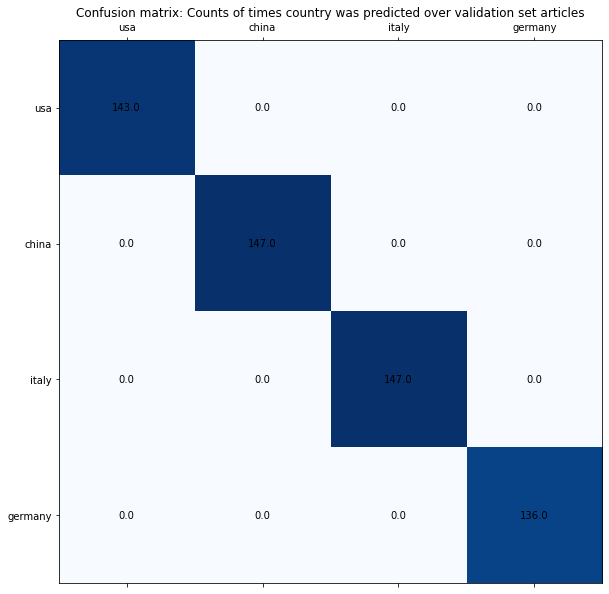

In [65]:
count_err_dict = Counter(list(zip(y_pred, y_valid_)))
count_err_matrix = np.zeros((4, 4))
for k, val in count_err_dict.items():
    count_err_matrix[k[0]-1][k[1]-1] = val
    
draw_count_err_matrix(count_err_matrix)